In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm

from tqdm import tqdm
from hurst import compute_Hc
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from itertools import combinations
from sklearn.decomposition import PCA
from arch.unitroot import engle_granger
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler

# Loading Data

In [2]:
# price_df = pd.read_csv('/Users/yjban/Desktop/MFE/BAF646_Statistical_arbitrage/project/data/us_etf_price.csv')
# etf_info = pd.read_csv('/Users/yjban/Desktop/MFE/BAF646_Statistical_arbitrage/project/data/etf_list/etfs_details_equity.csv')

In [3]:
def preprocessing(price_df, etf_info, start_date, end_date):

    price_df = price_df.astype({'Date': 'datetime64[ns]'})

    formation = price_df[(price_df.Date>=start_date) & (price_df.Date<end_date)]
    formation = formation.set_index('Date')

    formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())
    print('the number of ETF: ',len(formation_etf_list))

    close_df = pd.DataFrame(index = formation.index.unique())

    for x in tqdm(formation_etf_list):
        tmp = test = formation['Close'][formation.tic == x]
        close_df = pd.concat([close_df, tmp], axis=1)

    close_df.columns = formation_etf_list
    rtn_df = close_df.pct_change()[1:]

    etf_info['volume'] = etf_info['Avg. Daily Volume'].str.replace(',','').astype('float')
    low_volume_etf = etf_info[etf_info.volume < etf_info.volume.quantile(0.1)].Symbol.to_list()

    return formation, close_df, rtn_df, low_volume_etf

In [4]:
formation, close_df, rtn_df, low_volume_etf = preprocessing(price_df,etf_info, '2020-01-01', '2020-06-30')

the number of ETF:  1338


100%|██████████| 1338/1338 [00:13<00:00, 102.60it/s]


In [5]:
def get_pca_return(rtn_df, pc_selecting_threshold):
    rtn_df_scaled = pd.DataFrame(StandardScaler().fit_transform(rtn_df))
    pca = PCA()
    pca.fit(rtn_df_scaled)
    cumsum_eigen_value = np.cumsum(pca.explained_variance_ratio_)
    pca_components = pca.components_[:np.where(cumsum_eigen_value >= pc_selecting_threshold)[0][0]]

    pc_rtn = pd.DataFrame(data=pca_components.T, index=rtn_df.columns)
    pc_rtn = pc_rtn.add_prefix("P")

    return pc_rtn


In [6]:
pc_rtn = get_pca_return(rtn_df, 0.9)

In [7]:
pc_rtn

,P0,P1,P2,P3
IVE,-0.029221,0.003529,-0.030862,0.025127
SIL,-0.009413,-0.008761,0.027756,-0.166988
ROBO,-0.029276,0.012360,0.004822,-0.004585
FINX,-0.028756,0.011262,0.003073,-0.012118
FKU,-0.026165,-0.041417,0.029503,-0.032865
...,...,...,...,...
OVF,-0.027991,0.016033,0.022095,0.002227
BOUT,-0.025998,0.045600,-0.003555,-0.039280
XLE,-0.026629,-0.049261,0.013000,0.007371
PDEC,-0.028828,0.018330,-0.015147,-0.003908


In [8]:
def dbscan_clustering(pc_rtn, eps, min_samples, cluster_size_limit, cluster_member_counts):
    data = StandardScaler().fit_transform(pc_rtn)
    clf = DBSCAN(eps=eps, min_samples=min_samples)
    clf.fit(data)

    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered: %d" % n_clusters_)

    clustered = clf.labels_
    clustered_series = pd.Series(index = pc_rtn.index, data = clustered.flatten())
    clustered_series_all = pd.Series(index = pc_rtn.index, data = clustered.flatten())
    clustered_series = clustered_series[clustered_series != -1]

    counts = clustered_series.value_counts()
    ticker_count_reduced = counts[(counts > 1) & (counts <= cluster_size_limit)]
    print("Clusters formed: %d" % len(ticker_count_reduced))
    print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

    # tsne plot
    X_tsne = TSNE(learning_rate = 1000, perplexity = 25, random_state = 1337).fit_transform(pc_rtn)

    plt.figure(1, facecolor = 'white', figsize = (15, 10))
    plt.clf()
    plt.axis('off')

    plt.scatter(X_tsne[(labels!=-1), 0], X_tsne[(labels!=-1), 1], s = 100, alpha = 0.85, c = labels[labels!=-1], cmap = cm.Paired)
    plt.scatter(X_tsne[(clustered_series_all==-1).values, 0], X_tsne[(clustered_series_all==-1).values, 1], s = 100, alpha = 0.05)
    plt.title('T-SNE of all stocks with DBSCAN Clusters Noted')
    plt.savefig('T-SNE_plot_for_stock_clusters.png')
    plt.show()

    # 각 클러스터링 안에 etf 몇 개 있는지 보는 도표 출력
    plt.figure(figsize = (12, 7))
    plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
    plt.title("Cluster Memeber Counts")
    plt.xlabel('Stocks in Cluster')
    plt.ylabel("Cluster Member")
    plt.savefig('cluster_member_counts.png')
    plt.show()

    # 클러스터링 안에 etf가 너무 많으면 pair selection 시간 너무 많이 걸림. 너무 많은 etf 포함하고 있는 clustering 제외하기
    # cluster_memeber_counts 파라미터 조정 필요. 너무 크면 돌리는데 시간이 오래 걸리고, 너무 작으면 페어가 안뽑힐 수도 있음. 
    counts = clustered_series.value_counts()
    clusters_viz_list = list(counts[(counts < cluster_member_counts) & (counts > 1)].index)[::-1]
    print('final_clusters index : ', clusters_viz_list)

    # 최종 클러스트 내에 etf 가격 움직임 그래프
    for c in clusters_viz_list:
        stocks = list(clustered_series[clustered_series==c].index)
        means = np.log(close_df.T.loc[stocks,].T.mean())
        data = np.log(close_df.T.loc[stocks,]).T.sub(means)
        data.plot(title='Stock Time Series for Cluster %d' % c)
        plt.savefig('stock_price_clsuter_'+str(c)+'.png')
        plt.show()

    return clusters_viz_list, clustered_series

Clusters discovered: 3
Clusters formed: 2
Pairs to evaluate: 3438


/Users/yjban/tensorflow/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


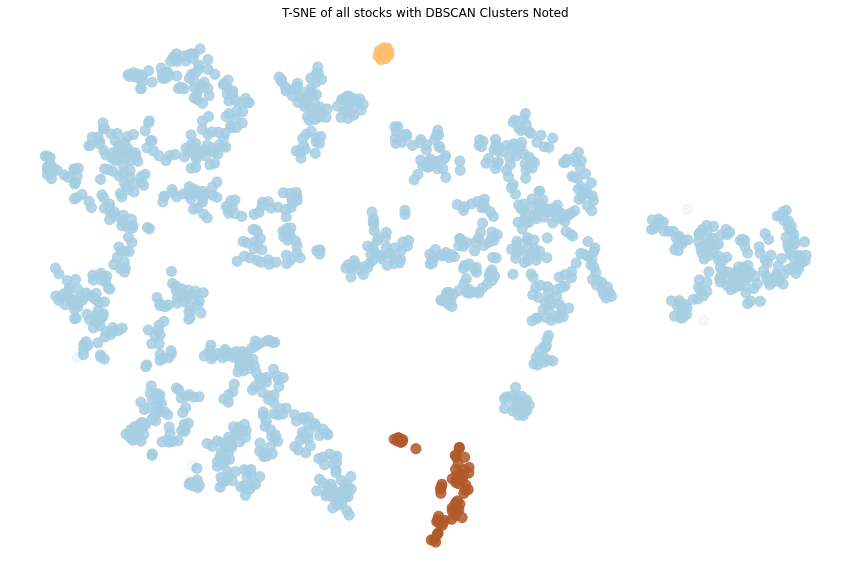

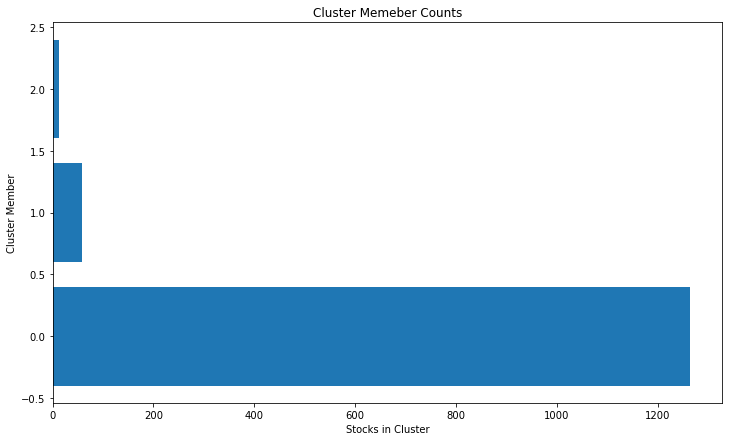

final_clusters index :  [1, 2]


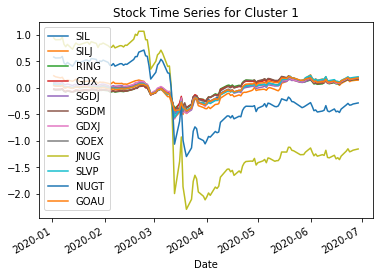

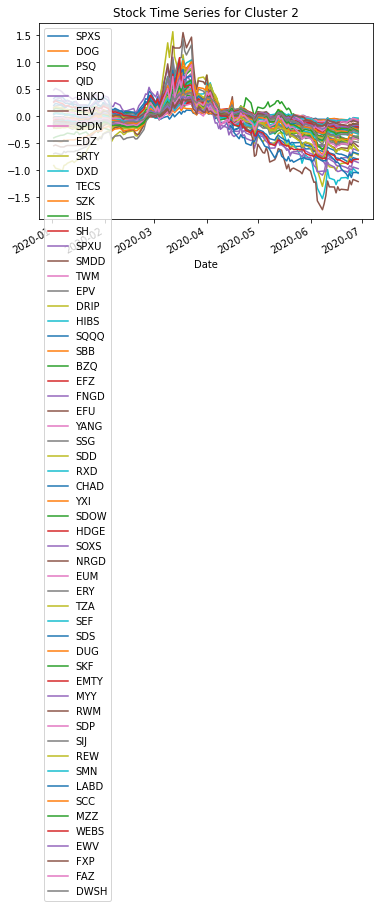

In [9]:
eps = 1.8
min_samples = 4
cluster_size_limit = 100
cluster_member_counts = 100

clusters_viz_list, clustered_series = dbscan_clustering(pc_rtn, eps, min_samples, cluster_size_limit, cluster_member_counts)

# Pair selection

In [24]:
rtn_df.corr()['IVE'].idxmin()

'DXD'

In [25]:
def Pair_selection(clusters_viz_list, clustered_series, inverse_threshold, coint_pvalue_threshold, hurst_threshold, half_life_threshold, mean_reverting_freq):
    
    selected_pair = []
    for i in tqdm(range(len(clusters_viz_list))):
        test_list = list(clustered_series[clustered_series == clusters_viz_list[i]].index)

        # 1. 거래량 10분위 이하 제거
        vol_screened_test_list = []
        for x in test_list:
            if (x in low_volume_etf) == False:
                vol_screened_test_list.append(x)       
                
        # 2. corr -0.99 보다 작은 etf가 존재하는지 -> 숏포지션 잡을 수 있는지 여부
        short_avail_test_list = []
        short_pair = {}
        for x in vol_screened_test_list:
            if rtn_df.corr()[x].min() < inverse_threshold:
                short_avail_test_list.append(x)
                short_pair[x] = rtn_df.corr()[x].idxmin()
                
        # 3. Cointegration - pvalue 0.05 이하인 pair sorting
        log_price_data = np.log(close_df[short_avail_test_list])
        comb = list(combinations(short_avail_test_list, 2))
        eg_pvalue = {}

        for x in tqdm(comb):
            score, pvalue, _ = coint(log_price_data[x[0]], log_price_data[x[1]], method='aeg')
            eg_pvalue[x] = pvalue

        possible_pair = [x[0] for x in sorted(eg_pvalue.items(), key=lambda item: item[1]) if x[1] <= coint_pvalue_threshold]

        # 4. Hurst exponent test - mean reverting intensity : H < 0.5 이하인 종목 선정
        spread_df = pd.DataFrame(index = log_price_data.index)

        for x in possible_pair:
            spread_df[x] = close_df[x[0]] - close_df[x[1]]
        
        hurst_screened_list = []

        for cnd in possible_pair:
            if compute_Hc(spread_df[cnd])[0] <= hurst_threshold:
                hurst_screened_list.append(cnd)

        spread_df = spread_df[hurst_screened_list]

        # 5. Half life가 trading period 안에 들어오는 종목 스크리닝
        spread_df_lag = spread_df.shift(1)
        spread_df_diff = spread_df - spread_df_lag

        hl_screened_list = []
        for i in range(len(hurst_screened_list)):
            X = sm.add_constant(spread_df_lag.iloc[1:,i])
            model = sm.OLS(spread_df_diff.iloc[1:,i], X)
            result = model.fit()
            lamda = result.params[1]
            HL = -np.log(2) / lamda

        # trading period 고려
            if (HL <= half_life_threshold) & (HL >= 1):
                hl_screened_list.append(hurst_screened_list[i])

        spread_df = spread_df[hl_screened_list]

        # 6. mean-reverting freq이 충분히 자주 발생하는지 스크리닝
        freq_screened_list = []

        for j in range(len(spread_df.columns)):

            cnt = 0

            for i in range(len(spread_df.index)):

                if i == len(spread_df.index) -1:
                    break

                elif spread_df.iloc[i+1,j] >= spread_df.iloc[i,j]:
                    if (spread_df.mean()[j] >= spread_df.iloc[i,j]) & (spread_df.mean()[j] <= spread_df.iloc[i+1,j]):
                        cnt += 1

                else:
                    if (spread_df.mean()[j] >= spread_df.iloc[i+1,j]) & (spread_df.mean()[j] <= spread_df.iloc[i,j]):
                        cnt += 1
            
            if cnt >= mean_reverting_freq:
                freq_screened_list.append(hl_screened_list[j])

        selected_pair.append(freq_screened_list)

    return selected_pair, short_pair

In [26]:
selected_pair, short_pair = Pair_selection(clusters_viz_list=clusters_viz_list, clustered_series=clustered_series, inverse_threshold=-0.99, coint_pvalue_threshold=0.05, hurst_threshold=0.5, half_life_threshold=30, mean_reverting_freq=12)

0it [00:00, ?it/s]/2 [00:00<?, ?it/s]
100%|██████████| 2/2 [00:41<00:00, 20.62s/it]


In [28]:
selected_pair

[[],
 [('EFZ', 'SEF'),
  ('SDP', 'FXP'),
  ('MYY', 'RWM'),
  ('DOG', 'SKF'),
  ('SKF', 'EWV'),
  ('EPV', 'SKF'),
  ('EEV', 'SKF'),
  ('YXI', 'SKF'),
  ('EEV', 'EWV'),
  ('SKF', 'MYY'),
  ('DOG', 'EWV'),
  ('EEV', 'RWM'),
  ('DOG', 'EEV')]]

In [30]:
short_pair['EFZ']

'IEFA'